In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')
import os
import random 
from glob import glob1
from scipy.ndimage import gaussian_filter1d as gf1d

import sdf
import happi

me = 9.1e-31 #electron mass
qe = 1.6e-19 #unit  charge
vc = 3e8 #speed of light
labda = 8e-7 #wavelength of laser
omega = 2*np.pi*vc/labda #frequency of laser
enorm = me*omega*vc/qe #normalized electric field
bnorm = me*omega/qe #normalized magnetic field
perd = labda/vc


pro = 'dla/'    
datapath = '../../epoch/epoch2d/Data/'+pro
plotpath = '../../epoch/epoch2d/Figure/'+pro
if os.path.exists(plotpath)==False:
    os.mkdir(plotpath)

cnts = 5#len(glob1(datapath,"*.sdf"))
partnum = 3
inidf = sdf.read(datapath+'0001.sdf',dict=True)
iniid = inidf['Particles/ID/electron'].data
findf = sdf.read(datapath+'0150.sdf',dict=True)
finx = findf['Grid/Particles/electron'].data[0]/1e-6
finy = findf['Grid/Particles/electron'].data[1]/1e-6
mask = (finx < 15) & (finy > -1.5) & (finy < 1.5) 
finid = findf['Particles/ID/electron'].data
finid = finid[mask]
insectid = np.intersect1d(iniid,finid)
#randomid = random.sample(list(insectid),partnum)
randomid = np.array([12628698,7237797,7231618,10849017,12080764])
sample_x = np.zeros([cnts-2,partnum])
sample_y = np.zeros_like(sample_x)
sample_px = np.zeros_like(sample_x)
sample_py = np.zeros_like(sample_x)
sample_pz = np.zeros_like(sample_x)
sample_ek = np.zeros_like(sample_x)
for i in range(1,cnts-1):
    df = sdf.read(datapath+str(i).zfill(4)+".sdf",dict=True)
    time = df['Header']['time']/1e-15
    pos = df['Grid/Grid_mid'].data
    x = pos[0]/1e-6
    y = pos[1]/1e-6
    posx = df['Grid/Particles/electron'].data[0]/1e-6
    posy = df['Grid/Particles/electron'].data[1]/1e-6
    px = df['Particles/Px/electron'].data/(me*vc)
    py = df['Particles/Py/electron'].data/(me*vc)
    pz = df['Particles/Pz/electron'].data/(me*vc)
    ek = np.zeros_like(px)
    #ek = df['Particles/Ek/electron'].data/(1e6*me)
    ide = df['Particles/ID/electron'].data
    for j in range(partnum):
        sample_x[i-1][j] = posx[ide==randomid[j]]
        sample_y[i-1][j] = posy[ide==randomid[j]]
        sample_px[i-1][j] = px[ide==randomid[j]]
        sample_py[i-1][j] = py[ide==randomid[j]]
        sample_pz[i-1][j] = pz[ide==randomid[j]]
        sample_ek[i-1][j] = np.sqrt(sample_px[i-1][j]**2+sample_py[i-1][j]**2+sample_pz[i-1][j]**2+1)-1
        sample_ek[i-1][j] = ek[ide==[random[j]]]
        
        
    #print(len(id))

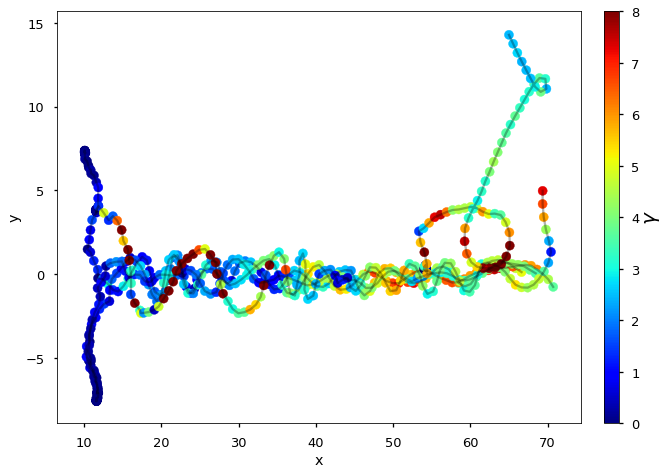

In [9]:
cmin,cmax = sample_ek.min(),sample_ek.max()
fig,ax = plt.subplots()
for k in range(np.shape(sample_x)[1]):
    ax.plot(sample_x[:,k],sample_y[:,k],'k-',alpha=0.3)
    im = ax.scatter(sample_x[:,k],sample_y[:,k],c=sample_ek[:,k],cmap='jet')
    im.set_clim(cmin,8)
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.subplots_adjust(bottom=0.1,top=0.9,left=0.1,right=0.8)
cax = fig.add_axes([0.83,0.1,0.02,0.8])
cbar = plt.colorbar(im,cax=cax)
cbar.set_label('$\gamma$',fontsize=20)
plt.show()

In [10]:
np.savetxt("x.txt",sample_x)
np.savetxt("y.txt",sample_y)
np.savetxt("ek.txt",sample_ek)
np.savetxt("px.txt",sample_px)
np.savetxt("py.txt",sample_py)
np.savetxt("pz.txt",sample_pz)

In [2]:
sample_x = np.loadtxt('x.txt')
sample_y = np.loadtxt('y.txt')

In [3]:
def plotfield(df,item,i):
    item = item.title()
    if item.startswith('E'):
        field = df['Electric Field/'+item].data/enorm
    else:
        field = df['Magnetic Field/'+item].data/bnorm
    vmax = np.max(np.abs(field))
    X,Y=np.meshgrid(x,y)
    if vmax<1e-3:
        vmax = 1
    levels = np.linspace(-vmax,vmax,30)
    
    fig,ax = plt.subplots()
    im = ax.contourf(X,Y,field.T,levels=levels,cmap='seismic')
    cbar = plt.colorbar(im,ax=ax,ticks=np.linspace(-vmax,vmax,5))
    #cbar.ax.tick_params(nbins=5)
    cbar.set_label('Normalized Field',fontdict=font)
    #ax.set_xlim(15,25)
    #ax.set_ylim(-5,5)
    ax.set_xlabel(r'X($\mu m$)',fontdict=font)
    ax.set_ylabel(r'Y($\mu m$)',fontdict=font)
    ax.set_title(item+' at t= '+str(round(time/perd,1))+r'$T_L$',fontdict=font)
    
def plotspec(df,part,i):
    ek = df['Particles/Ek/'+part].data/1.6e-13
    wt = df['Particles/Weight/'+part].data
    bins,nums = np.histogram(ek,bins=1000,weights=wt)
    nums = gf1d(nums,2)
    
    fig,ax = plt.subplots()
    ax.semilogy(bins,nums)
    ax.set_xlabel('Energy')
    ax.set_ylabel('Numbers(a.u.)')
    

In [3]:
font = {'family':'Dejavu Sans Mono',
        'color':'black',
        'weight':'normal',
        'size':20}
perd = labda/vc
df = sdf.read('../../epoch/epoch2d/Data/dla/0130.sdf',dict=True)
time = df['Header']['time']/1e-15
pos = df['Grid/Grid_mid'].data
x = pos[0]/1e-6
y = pos[1]/1e-6
posx = df['Grid/Particles/electron'].data[0]/1e-6
posy = df['Grid/Particles/electron'].data[1]/1e-6
field = df['Magnetic Field/Bz'].data/bnorm

#diffden = np.log(1+diffden.T)

In [ ]:
font = {'family':'Dejavu Sans Mono',
        'color':'black',
        'weight':'normal',
        'size':20}
perd = labda/vc
df = sdf.read('../../epoch/epoch2d/Data/dla/0130.sdf',dict=True)
time = df['Header']['time']/1e-15
pos = df['Grid/Grid_mid'].data
x = pos[0]/1e-6
y = pos[1]/1e-6
posx = df['Grid/Particles/electron'].data[0]/1e-6
posy = df['Grid/Particles/electron'].data[1]/1e-6
field = df['Magnetic Field/Bz'].data/bnorm
fig,axes = plt.subplots(2,2,figsize=(10,10),tight_layout=True)

vmax = np.max(np.abs(field))
X,Y=np.meshgrid(x,y)
if vmax<1e-3:
    vmax = 1
levels = np.linspace(-2,2,30)
im = axes[0,0].contourf(X,Y,field.T,levels=levels,cmap='seismic')
cbar = plt.colorbar(im,ax=axes[0,0],ticks=np.linspace(-2,2,3))
#cbar.ax.tick_params(nbins=5)
cbar.set_label('Normalized Field',fontdict=font)
#ax.set_xlim(15,25)
#ax.set_ylim(-5,5)
axes[0,0].set_xlabel(r'X($\mu m$)',fontdict=font)
axes[0,0].set_ylabel(r'Y($\mu m$)',fontdict=font)
axes[0,0].set_title('Bz at t= '+str(round(time/perd*1e-15,1))+r'$T_L$',fontdict=font)
colors = ['tab:blue','tab:brown','tab:green','tab:olive','tab:purple']
for k in range(np.shape(sample_x)[1]):
    axes[0,1].plot(sample_x[:,k],sample_y[:,k],color=colors[k],alpha=0.7)
    #im = ax.scatter(sample_x[:,k],sample_y[:,k],c=sample_ek[:,k],cmap='jet')
    #im.set_clim(cmin,8)
axes[0,1].set_xlabel(r'x($\mu m$)')
axes[0,1].set_ylabel(r'y($\mu m$)')
axes[0,1].set_xlim(0,80)
axes[0,1].set_ylim(-15,15)
axes[0,1].set_title('Selected Electrons\' Trajectories')

    
im1 = axes[1,0].pcolormesh(X,Y,-dendata[0].T,cmap='viridis',norm=colors.LogNorm(vmin=nums.min()+1,vmax=nums.max()))
cbar1 = fig.colorbar(im1,ax=axes[1,0])
#cbar.ax.locator_params(nbins=5)
cbar1.ax.tick_params(labelsize=12)
axes[1,0].set_xlim(0,80)
axes[1,0].set_ylim(-10,10)
axes[1,0].set_xlabel(r'X$(\mu m)$')
axes[1,0].set_ylabel(r'Y$(\mu m)$')
axes[1,0].set_title('Electron Density at t= '+str(time/perd*1e-15)+r'$T_L$')

ek = df['Particles/Ek/'+part].data/1.6e-13
wt = df['Particles/Weight/'+part].data
bins,nums = np.histogram(ek,bins=1000,weights=wt)
nums = gf1d(nums,2)

fig,ax = plt.subplots()
axes[1,1].semilogy(bins,nums)
axes[1,1].set_xlabel('Energy')
axes[1,1].set_ylabel('Numbers(A.U.)')

In [ ]:
wt = df['Particles/Weight/electron'].data
nums,bin1,bin2 = np.histogram2d(posx,posy,range=[[0,40],[-20,20]],bins=[1e3,1e3],weights=wt)

In [5]:
import happi
rad = happi.Open('../rad')

Loaded simulation '../rad'
Scanning for Scalar diagnostics
Scanning for Field diagnostics
Scanning for Probe diagnostics
Scanning for ParticleBinning diagnostics
Scanning for RadiationSpectrum diagnostics
Scanning for Performance diagnostics
Scanning for Screen diagnostics
Scanning for Tracked particle diagnostics


In [6]:
elec_den = rad.Field(0,"Rho_electron")

Field diagnostic #0: Rho_electron


/gpfs/share/software/anaconda37/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


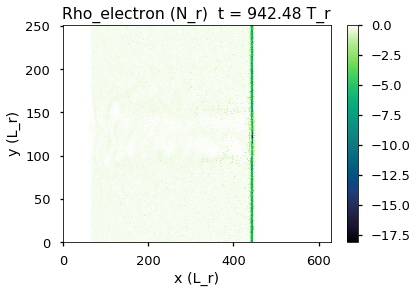

In [7]:
elec_den.plot()

In [7]:
dendata = elec_den.getData(timestep = 360*24)

In [8]:
import matplotlib.pyplot as plt
import numpy as np
x = elec_den.getAxis("x")
y = elec_den.getAxis("y")
x = x/x[-1]*100
y = y/y[-1]*40
X,Y= np.meshgrid(x,y)

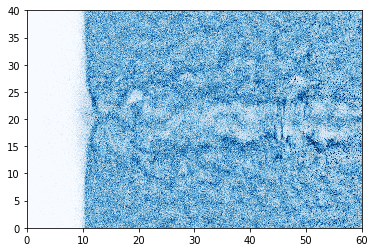

In [10]:
im = plt.pcolormesh(X,Y,-dendata[0].T,cmap = 'Blues')
plt.xlim(0,60)
plt.clim(0,0.4)

In [19]:
part='electron'
df = sdf.read('../../epoch/epoch2d/Data/dla/0130.sdf',dict=True)
ek = df['Particles/Ek/'+part].data/1.6e-13
wt = df['Particles/Weight/'+part].data
nums,bins = np.histogram(ek,bins=1000,weights=wt)
nums = gf1d(nums,2)
bins = (bins[1:]+bins[:-1])/2

(0.511, 40)

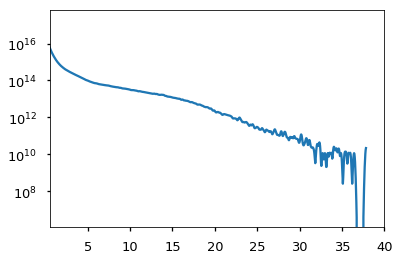

In [21]:
plt.semilogy(bins,nums)
plt.xlim(0.511,40)

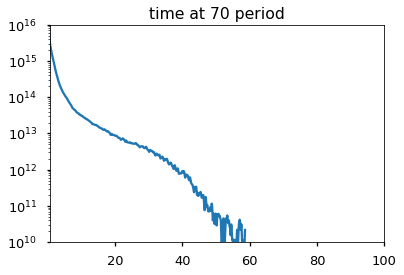

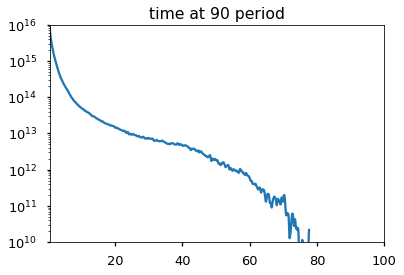

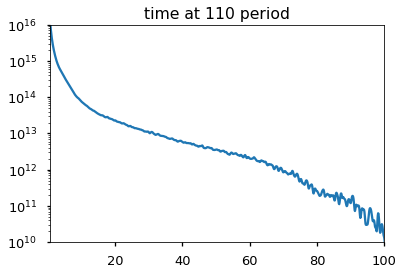

In [5]:
for i in [70,90,110]:
    part='electron'
    df = sdf.read('../../epoch/epoch2d/Data/dla/'+str(i).zfill(4)+'.sdf',dict=True)
    ek = df['Particles/Ek/'+part].data/1.6e-13
    wt = df['Particles/Weight/'+part].data
    nums1,bins1 = np.histogram(ek,bins=1000,weights=wt)
    nums1 = gf1d(nums1,2)
    bins1 = (bins1[1:]+bins1[:-1])/2
    np.savetxt('bin'+str(i)+'.txt',bins1)
    np.savetxt('num'+str(i)+'.txt',nums1)
    plt.semilogy(bins1,nums1)
    plt.ylim(1e10,1e16)
    plt.xlim(0.511,100)
    plt.title('time at '+ str(i)+' period')
    plt.show()

In [28]:
xpos = np.loadtxt('../../xpos.txt')
ypos = np.loadtxt('../../ypos.txt')
elec_den = np.loadtxt('../../elec_den.txt')

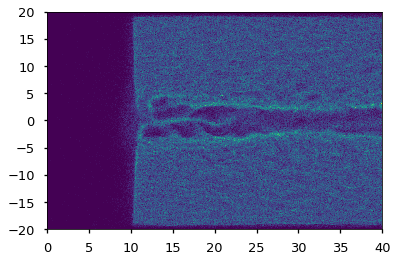

In [30]:
plt.pcolormesh(xpos,ypos,elec_den.T)